# BIM Project: Nitroreductase

**Arthur VINCENS & Sofia TERKI**

## Import libraries

In [1]:
from Bio import SeqIO
import random
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

## Data

### Sample sequences 

In [20]:
# Load all sequences from the FASTA file
seq_file = "PF00881_final.fasta"
sequences = list(SeqIO.parse(seq_file, "fasta"))
n_sample = 100000 # number of sequences to sample

# Check if there are at least n_sample sequences
if len(sequences) < n_sample:
    raise ValueError("The file does not contain enough sequences.")

# Randomly select n_sample sequences
sampled_sequences = random.sample(sequences, n_sample)

# Save the extracted sequences to a new file
output_file = "sampled_seqs.fasta"

with open(output_file, "w") as out_f:
    for seq_record in sampled_sequences:
        out_f.write(f">{seq_record.id}\n{str(seq_record.seq)}\n") #to write each seq in a line

print(f"{n_sample} sequences have been extracted and saved in {output_file}.")



100000 sequences have been extracted and saved in sampled_seqs.fasta.


### Numerical encoding

In [21]:
aa_num = {
    "-": 0,  # Gap
    "A": 1, "C": 2, "D": 3, "E": 4, "F": 5,
    "G": 6, "H": 7, "I": 8, "K": 9, "L": 10,
    "M": 11, "N": 12, "P": 13, "Q": 14, "R": 15,
    "S": 16, "T": 17, "V": 18, "W": 19, "Y": 20
}

def num_encoding(seq, aa_num):
   """ 
   Encode each amino acid of a given sequence into a number between 0 and 20.

   Parameters:
   -seq (str): Protein sequence consisting of amino acid letters.
   -aa_num (dict): Dictionary mapping amino acids and gaps to numerical values.

   Returns:
   list[int]: Encoded sequence as a list of integers.
   """

   if any(aa not in aa_num for aa in seq):
      return []  # Ignore sequences with letters not in the dictionary

   seq_num = [aa_num[aa] for aa in seq]
   return seq_num


def num_matrix(fasta_file):
   """
   Converts protein sequences from a FASTA file into a numerical matrix.

   Reads a FASTA file containing protein sequences and encodes them into a numerical matrix,
   where each amino acid is represented by an integer. Sequences with unrecognized characters are ignored.

   Parameters:
   - fasta_file (str): Path to the FASTA file containing protein sequences.

   Returns:
   - np.array: Numerical matrix where each row corresponds to an encoded protein sequence.
   """
   seqs = []
   with open (fasta_file, 'r') as f:
      lines = f.readlines()
      for line in lines:
         if line[0]!= '>':
            seq = num_encoding(list(line.strip()), aa_num)
            if seq != []:
               seqs.append(seq)
   return np.array(seqs)

num_seq = num_matrix("sampled_seqs.fasta")

### One hot encoding

In [22]:
def one_hot_encoding(matrix, num_classes=21):
   """
   Convert a numerical matrix into a one-hot encoded 3D matrix using numpy.
   
   Parameters:
   - matrix (numpy.ndarray): 2D array with numericzlly encoded AA
   - num_classes (int): Number of unique classes (here 21 for amino acids + gap)

   Returns:
   - numpy.ndarray: One-hot encoded sequence matrix
   """
   identity = np.eye(num_classes, dtype=int)  # Create a 21×21 identity matrix
   return identity[matrix]  # Direct indexing for efficiency

one_hot_matrix = one_hot_encoding(num_seq)

# Reshape the one-hot matrix to 2D
n_samples, sequence_length, n_features = one_hot_matrix.shape
one_hot_matrix_flattened = one_hot_matrix.reshape(n_samples, sequence_length * n_features)
print(one_hot_matrix.shape)
print(one_hot_matrix_flattened.shape)

(99382, 167, 21)
(99382, 3507)


## Dimensional reduction

### PCA

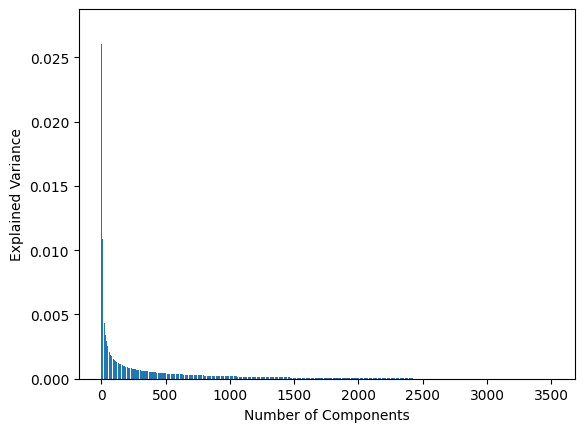

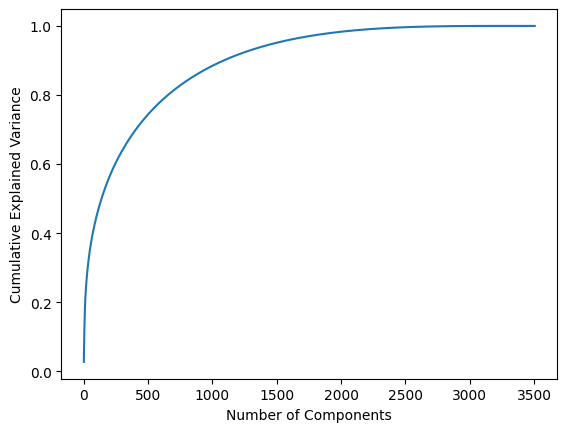

In [11]:
# Fit PCA without specifying the number of components to compute variance ratios for all components
pca = PCA().fit(one_hot_matrix_flattened)

# Plot the explained variance ratio for each principal component
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))  # Cumulative sum of explained variance
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

We can see that with ~1000 components out of ~3500 components, ~90% of the variability of the data is explained

In [18]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(one_hot_matrix_flattened)

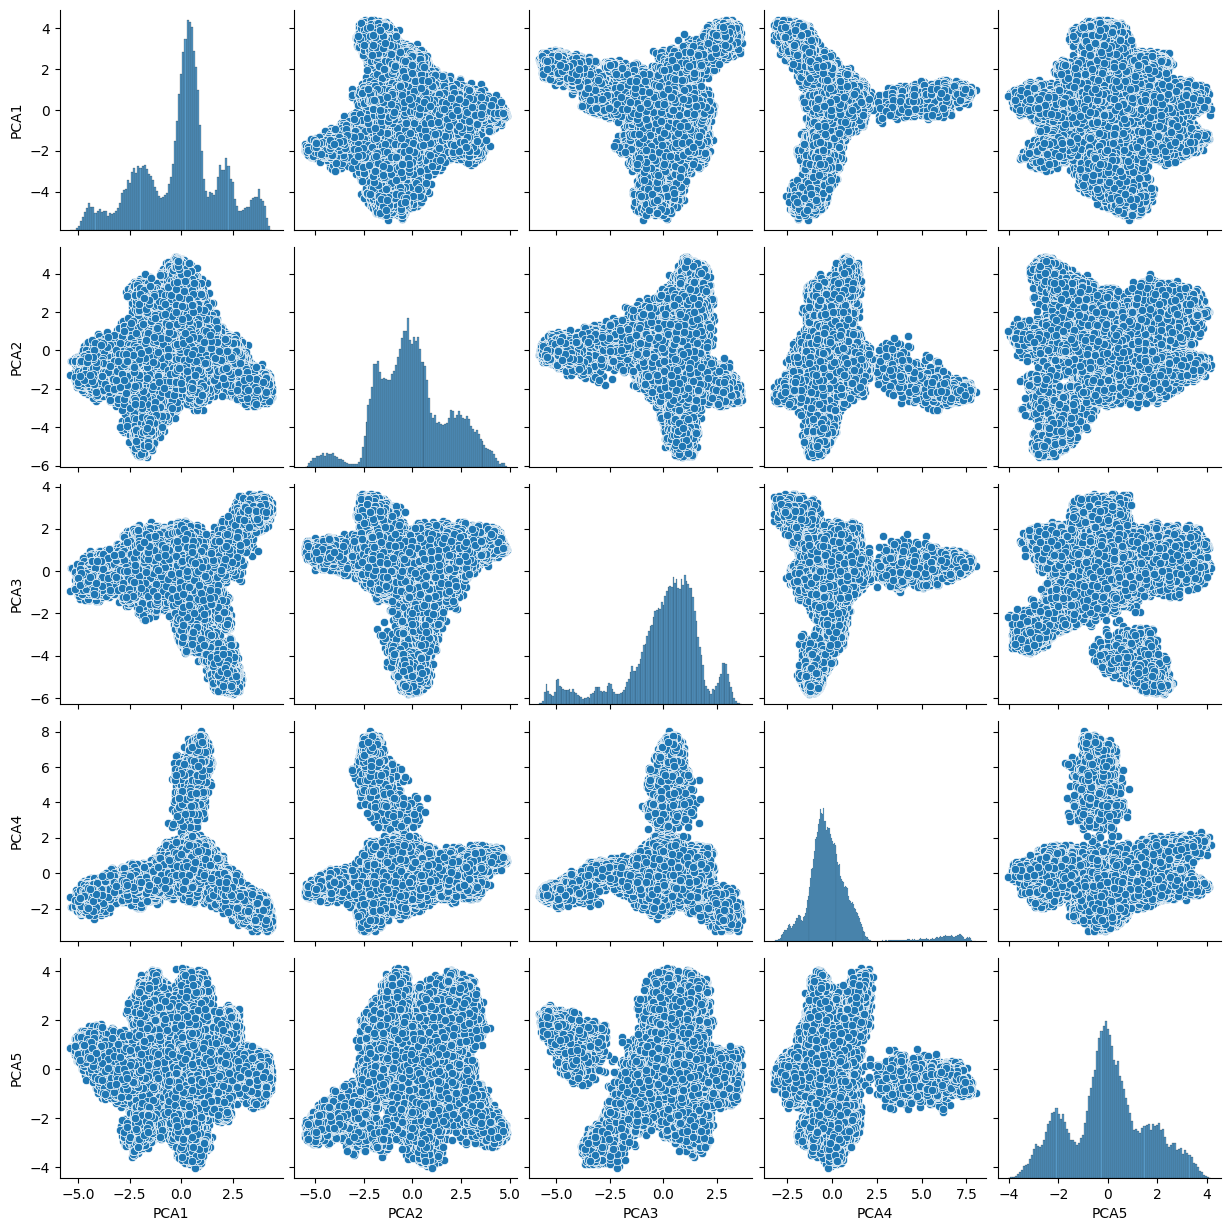

In [19]:
# Create a Data Frame with the 5 first principle components
components = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
compos = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']

# Plot the pair components plot using seaborn
pair_plot = sns.pairplot(components, diag_kind="hist")
plt.show()

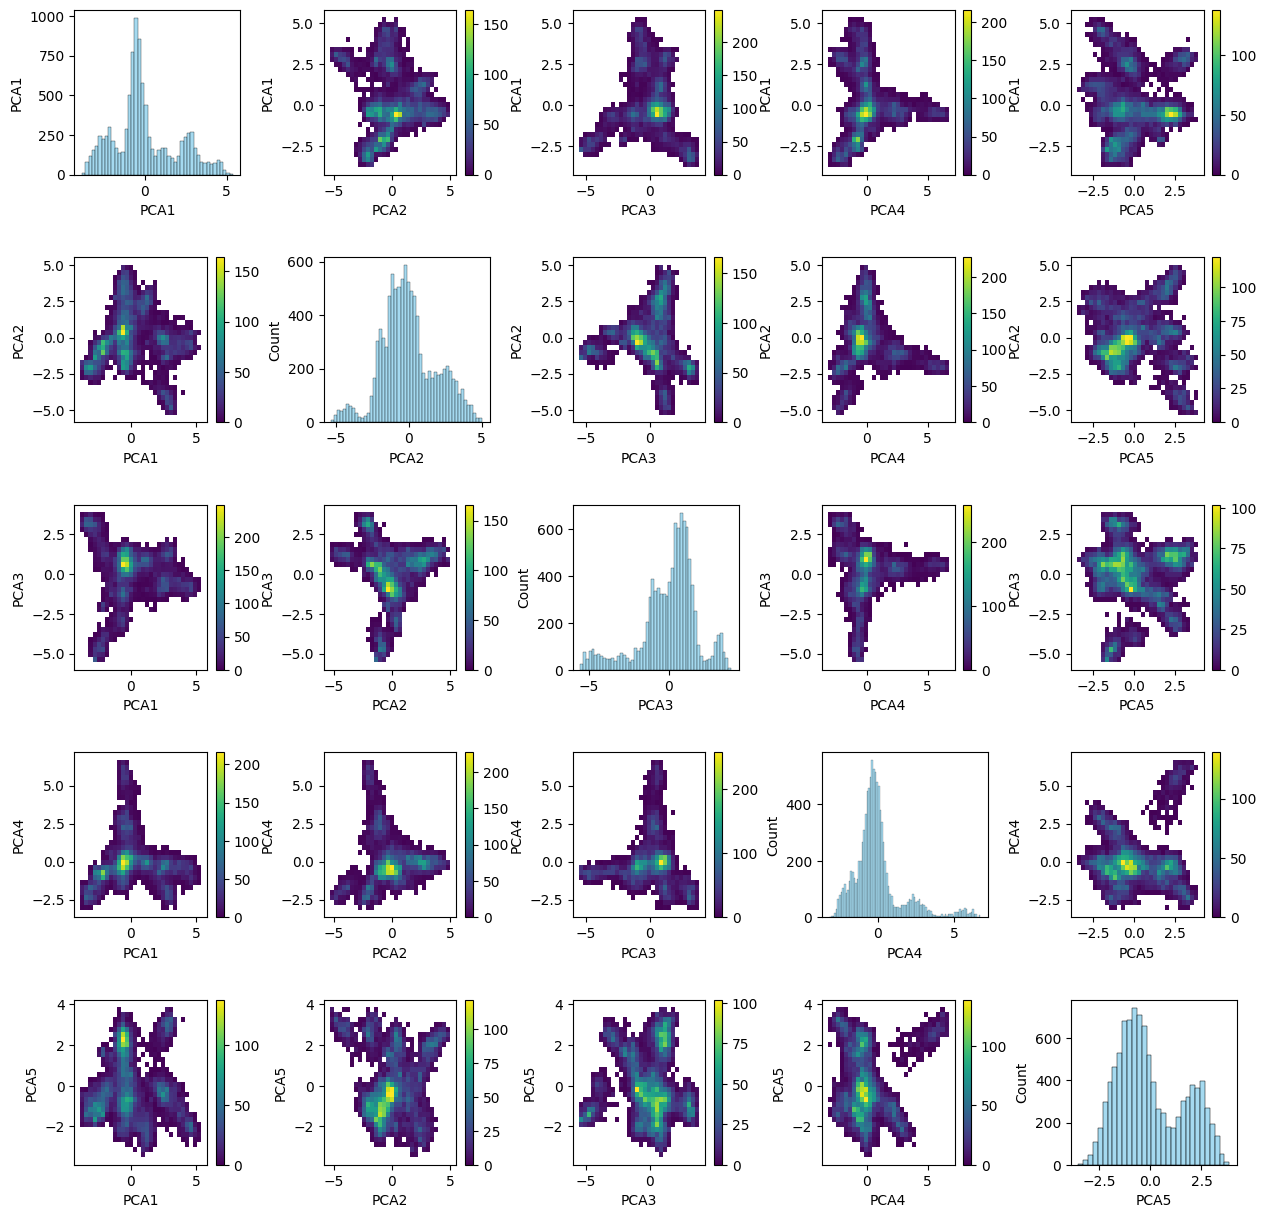

In [17]:
# Créer un pair plot avec des heatmaps
# Créer un pair plot avec des histogrammes 2D et 1D
def hist2d_pairplot(df):
    # Créer une grille de sous-graphiques
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    # Parcourir chaque paire de composantes principales
    for i in range(5):
        for j in range(5):
            ax = axes[i, j]
            if i == j:
                # Diagonale : histogramme 1D
                sns.histplot(df.iloc[:, i], ax=ax, kde=False, color='skyblue')
            else:
                # Hors diagonale : histogramme 2D
                sns.histplot(x=df.iloc[:, j], y=df.iloc[:, i], ax=ax, bins=30, cmap='viridis', cbar=True)

            # Ajouter des labels
            if i == 4:
                ax.set_xlabel(df.columns[j])
            if j == 0:
                ax.set_ylabel(df.columns[i])

    plt.show()

# Tracer le pair plot avec des histogrammes 2D et 1D
hist2d_pairplot(components)

### T-SNE

Shape of the t-SNE transformed data:  (9943, 2)


Text(0.5, 1.0, 'Scatter plot of the t-SNE transformed data')

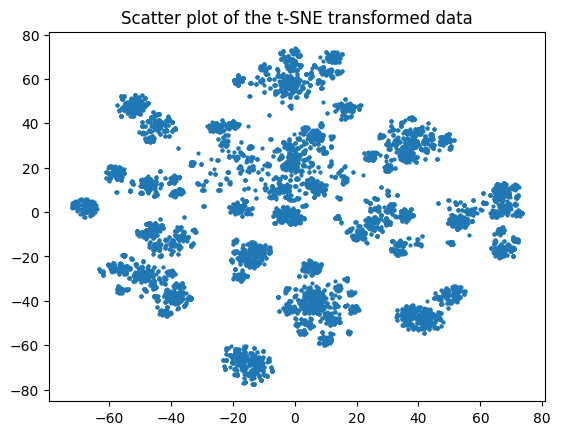

In [19]:
# Initialize t-SNE to reduce the dimensionality to 2 components with a specified perplexity
tsne = TSNE(n_components=2, perplexity=90)

# Apply t-SNE to the data
X_embedded = tsne.fit_transform(one_hot_matrix_flattened)

# Print the shape of the t-SNE transformed data
print("Shape of the t-SNE transformed data: ", X_embedded.shape)

# Create a scatter plot of the t-SNE transformed data
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=4)
plt.title("Scatter plot of the t-SNE transformed data")

## Clustering

### Kmeans

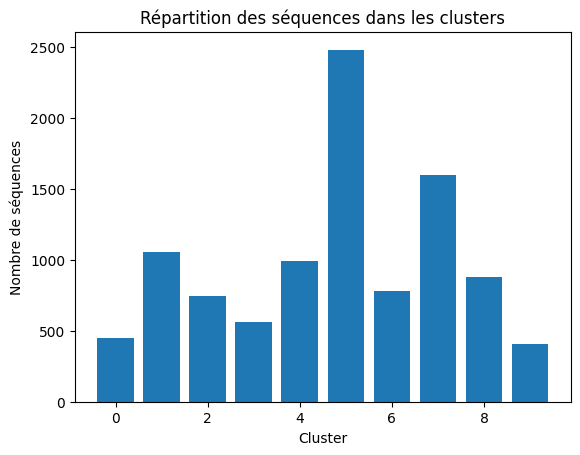

In [ ]:
# We first set the number of clusters to 10 and then we fit the KMeans model
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(one_hot_matrix_flattened)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

cluster_counts = Counter(labels)
plt.bar(cluster_counts.keys(), cluster_counts.values())
plt.xlabel("Clusters")
plt.ylabel("Number of sequences")
plt.title("Number of sequences per cluster")
plt.show()

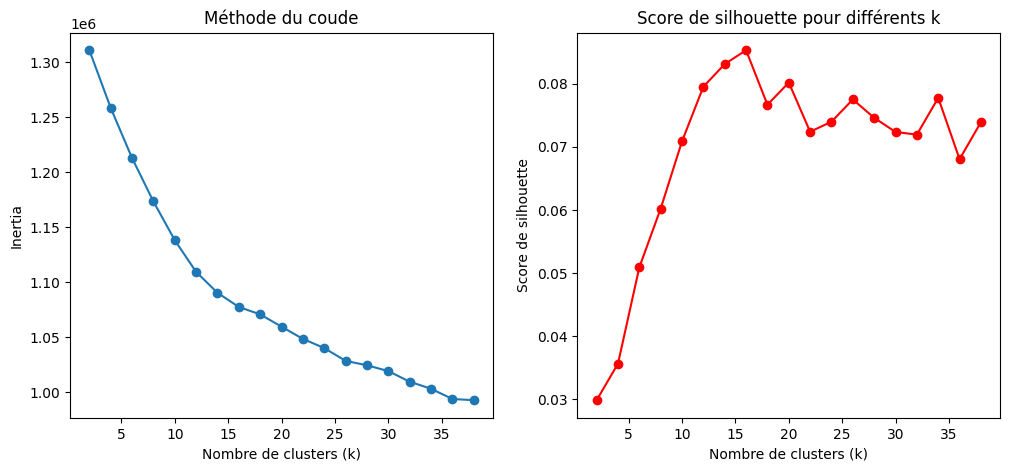

In [6]:
inertia = []
silhouette_scores = []
k_values = range(2, 40, 2)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(one_hot_matrix_flattened)
    inertia.append(kmeans.inertia_)  # Somme des distances intra-clusters
    silhouette_scores.append(silhouette_score(one_hot_matrix_flattened, kmeans.labels_))

# Tracer la courbe du coude
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertia")
plt.title("Méthode du coude")

# Tracer le score de silhouette
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='red')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.title("Score de silhouette pour différents k")

plt.show()

We can see that 12 is the optimal number of clusters.

Now we plot the clusters on the PCA results.

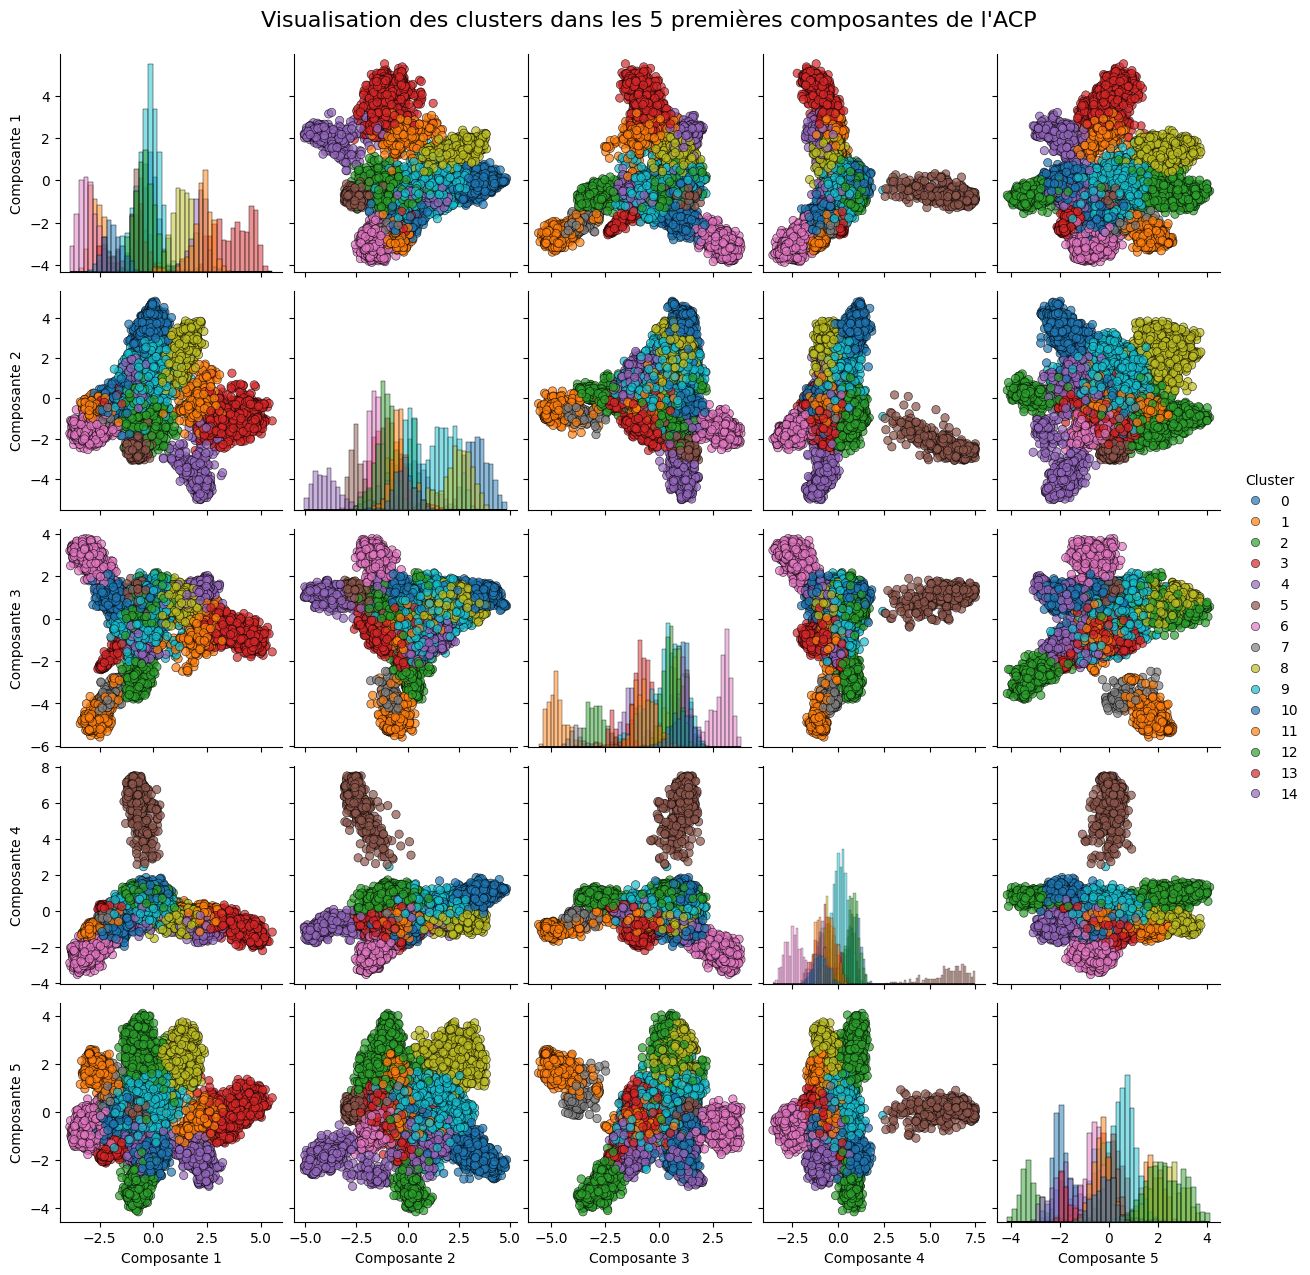

In [7]:
pca = PCA(n_components=5)
one_hot_pca = pca.fit_transform(one_hot_matrix_flattened)

k = 15
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(one_hot_matrix_flattened)

df_pca = pd.DataFrame(one_hot_pca, columns=[f"Composante {i+1}" for i in range(5)])
df_pca["Cluster"] = clusters  # Ajout des labels de cluster

sns.pairplot(df_pca, hue="Cluster", palette="tab10", diag_kind="hist", plot_kws={'alpha':0.7, 'edgecolor':'k'})

plt.suptitle("Visualisation des clusters dans les 5 premières composantes de l'ACP", fontsize=16, y=1.02)
plt.show()

faire la meme sur tnsne

In [95]:
labels = {"A0R2V4":"Acg", "Q92PC8":"BluB",  "Q9DCX8": "lyD", "F4KU78":"lyD", 'Q6PHW0':"lyD", 'A0R6D0':'PnbA', 'X5M410':'PnbA', 'A9CIP6':'Unk1', 'P0ACY1':'Unk1', 'B8FRE0':'Unk2', 'Q5LDN3':'Unk2', 'Q81HL8':'Unk3', 'Q8KFI1':'Unk6', 'C9YJD4':'Unk6', 'Q9WYL7':'TdsD', 'A9CKT4':'TdsD', 'Q81EW9':'Frm2', 'Q9CED0':'Frm2', 'Q8DW21':'Frm2', 'P37261':'Frm2', 'P9WP79':'FbiB', 'Q5LB10':'SagB', 'Q472T4':'SagB', 'B8HTZ1':'SagB', 'Q3MB62':'SagB', 'A0A0H2VHN8':'MhqN', 'P96692':'MhqN', 'U6C5W9':'MhqN', 'B1YG32':'MhqN', 'Q8DVW4':'MhqN', 'Q7MX99': 'Hub', 'Q180K0': 'Hub', 'Q60049': 'Hub', 'A6LRC1': 'Hub', 'Q8ABC9': 'Hub', 'Q97IT9': 'Hub', 'Q39RS1': 'Hub', 'A0PZS2': 'Hub', 'Q74GM9': 'Hub', 'Q314Q8': 'Hub', 'Q17ZU8': 'Hub', 'Q182R2': 'Hub', 'C9YJL7': 'Hub', 'P17117': 'NfsA', 'P39605': 'NfsA', 'P94424': 'NfsA', 'Q87FS7': 'NfsA', 'A0A0K0VJM8': 'NfsA', 'Q56691': 'NfsA', 'Q5L9C9': 'NfsA', 'Q7BGI8': 'NfsB', 'O25608': 'NfsB', 'Q01234': 'NfsB', 'P46072': 'NfsB', 'P15888': 'NfsB', 'Q9A120': 'NfsB', 'Q5R179': 'NfsB', 'A0A0H2UP38': 'NfsB', 'P38489': 'NfsB', 'Q9X1S2':'remainder'}

In [ ]:
# Charger les séquences du fichier FASTA
def load_sequences(fasta_file):
    return {record.id: str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")}

# Charger les séquences étiquetées
labeled_sequences = load_sequences("label_seqs_final.fasta")
label_seq = []
for seq_id, label in labels.items():
    labeled_sequences[seq_id] = label

# Charger toutes les séquences
all_sequences = load_sequences("PF00881_final.fasta")

# Trouver les séquences correspondantes
matching_sequences = {seq_id: seq for seq_id, seq in all_sequences.items() if seq_id in labeled_sequences}

{'44|sp|P39605|NFRA1_BACSU': 'ILNHRSIRSFTDQLLTAEEIDTLVKSAQAASTSSYVQAYSIIGVSDPEKKRELSVLAGNQPYVEKNGHFFVFCADLYRHQQLAEEKGEHIS------------ELLENTEMFMVSLIDAALAAQNMSIAAESMGLGICYIGGIRNELVTEVLQTPDVLPLFGLAVGH', '52|sp|Q01234|NFSB_ENTCL': '-LKRHSTKAFDASKLTAEEAEKIKTLLQYSPSSTNSQPWHFIVASTEEGKARVAKSAAGTYVFNERKMLDASHVV----VFCAKTAMDDAWLERVVRTYFADMHRVDLKDDDQWMAKQVYLNVGNFLLGVGAMGLDAVPIEGFDAAILDEEFGLKEFTSLVVVPVGH', '31|tr|Q180K0|Q180K0_CLOD6': '-KKRYSCRNYQDRKVEKEKLEKVLDVARIAPTGGNRQPQRLIVIQEKEGINKL----------------------------SKAANIYDAPLAILVCGDKDKVWTRP-FDGKQLTDIDTSIVTDHMMLQATELGLASVWVCYFNPDIIREEFSLPDLEPINILLMGY', '42|tr|C9YJL7|Release': 'LKKRRSIRKYKDVEVEKEKLDKILKAALLAPSSKGLRTWEFIVVDD-----------KEKLINLSQCRT-----------KGGGFFLKNAPLAIVI---------IADKEKNDVWIEDASIAASYIQLQAHELGLGSCWIQVRNE-AIREELKVPSYSVECIISIGY', '04|sp|Q6PHW0|IYD1_HUMAN': '-NKRRSVRFISNEQVPMEVIDNVIRTAGTAPSGAHTEPWTFVVVKDPDVKHKIRKIIEEEEEINYMKRMGHRWVTDLLRTNWIKEYLDTAPILILIFKQVHGFAANGKKKVHYYNEISVSIACGILLAALQNAGLVTVTTTPLNGPRLRVLLGRPAEKLLMLLPVGY', '32|sp|Q6

In [23]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import concurrent.futures
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from torch.utils.data import DataLoader, TensorDataset

# Paramètres
SEED = 12
input_shape = (167, 21)
latent_dim = 10 # A changer
batch_size = 256
epochs = 400
learning_rate = 1e-3 # reduce to 1e-4

# Définition de l'encodeur
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_shape[0] * input_shape[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        z_mean = self.fc_mean(x)
        z_logvar = self.fc_logvar(x)
        return z_mean, z_logvar

# Définition du décodeur
class Decoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, input_shape[0] * input_shape[1])

    def forward(self, z):
        x = torch.relu(self.fc1(z))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)
        x = x.view(x.size(0), input_shape[0], input_shape[1])
        return x

# Définition du VAE
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_shape, latent_dim)
        self.decoder = Decoder(input_shape, latent_dim)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        recon_x = self.decoder(z)
        return recon_x, z_mean, z_logvar

# Modèle
model = VAE(input_shape, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
import torch
from torchviz import make_dot

x = torch.randn(1, 167, 21)
# Passer le tenseur à travers le modèle pour obtenir le graphe de calcul
recon_x, z_mean, z_logvar = model(x)

# Générer le graphe de calcul
make_dot(recon_x, params=dict(model.named_parameters())).render("vae_architecture", format="png")

'vae_architecture.png'

In [24]:
# one_hot_matrix est de taille (9940, 167, 21)
Xtrain, Xtest, _, _ = sklearn.model_selection.train_test_split(one_hot_matrix, one_hot_matrix, test_size=0.25, random_state=SEED)

Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
Xtest = torch.tensor(Xtest, dtype=torch.float32)
train_dataset = TensorDataset(Xtrain, Xtrain)
test_dataset = TensorDataset(Xtest, Xtest)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Fonction de perte
def vae_loss(recon_x, x, z_mean, z_logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + kl_div

In [9]:
best_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in tqdm.tqdm(range(epochs)):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, z_mean, z_logvar = model(data)
        loss = vae_loss(recon_batch, data, z_mean, z_logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Validation
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            recon_batch, z_mean, z_logvar = model(data)
            loss = vae_loss(recon_batch, data, z_mean, z_logvar)
            test_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')
        print(f'Test Loss: {test_loss / len(test_loader.dataset)}')

    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

  0%|          | 1/400 [00:06<41:23,  6.22s/it]

Epoch 1, Loss: 1194.323984808923
Test Loss: 1142.0424684415373


  3%|▎         | 11/400 [01:07<39:33,  6.10s/it]

Epoch 11, Loss: 1059.1788018883824
Test Loss: 1062.6142558079646


  5%|▌         | 21/400 [02:11<39:59,  6.33s/it]

Epoch 21, Loss: 1049.1843270169243
Test Loss: 1054.7210326155996


  8%|▊         | 31/400 [03:15<39:10,  6.37s/it]

Epoch 31, Loss: 1044.892009623028
Test Loss: 1051.803841271608


 10%|█         | 41/400 [04:24<41:29,  6.93s/it]

Epoch 41, Loss: 1042.4156542845597
Test Loss: 1050.2164208870392


 13%|█▎        | 51/400 [05:30<38:31,  6.62s/it]

Epoch 51, Loss: 1040.702754331264
Test Loss: 1049.3632952817482


 15%|█▌        | 61/400 [06:36<36:50,  6.52s/it]

Epoch 61, Loss: 1039.479817917958
Test Loss: 1048.825075826466


 18%|█▊        | 71/400 [07:41<36:03,  6.58s/it]

Epoch 71, Loss: 1038.5806444783198
Test Loss: 1048.3169492825807


 20%|██        | 81/400 [08:47<35:01,  6.59s/it]

Epoch 81, Loss: 1037.764402993272
Test Loss: 1048.052992488416


 23%|██▎       | 91/400 [09:54<34:55,  6.78s/it]

Epoch 91, Loss: 1037.094827208521
Test Loss: 1047.8924325800053


 25%|██▌       | 101/400 [11:01<33:01,  6.63s/it]

Epoch 101, Loss: 1036.608630727783
Test Loss: 1047.9121838965527


 28%|██▊       | 111/400 [12:07<32:05,  6.66s/it]

Epoch 111, Loss: 1036.1200623444586
Test Loss: 1047.558363071206


 30%|███       | 121/400 [13:15<31:33,  6.79s/it]

Epoch 121, Loss: 1035.6823619433208
Test Loss: 1047.348407164697


 33%|███▎      | 131/400 [14:23<29:49,  6.65s/it]

Epoch 131, Loss: 1035.3580423638782
Test Loss: 1047.3936724441307


 35%|███▌      | 141/400 [15:30<28:59,  6.72s/it]

Epoch 141, Loss: 1035.013986154713
Test Loss: 1047.394463528146


 38%|███▊      | 151/400 [16:36<27:32,  6.64s/it]

Epoch 151, Loss: 1034.742228376801
Test Loss: 1047.3393293704846


 40%|███▉      | 158/400 [17:30<26:48,  6.65s/it]

Early stopping triggered


In [37]:
# Chemin où vous souhaitez sauvegarder les paramètres
save_path = 'vae_model_parameters.pth'

# Sauvegarde des paramètres du modèle
torch.save(model.state_dict(), save_path)
print(f"Paramètres du modèle sauvegardés à {save_path}")

Paramètres du modèle sauvegardés à vae_model_parameters.pth


In [38]:
# Sauvegarde de l'optimiseur
optimizer_save_path = 'optimizer_state.pth'
torch.save(optimizer.state_dict(), optimizer_save_path)
print(f"État de l'optimiseur sauvegardé à {optimizer_save_path}")

État de l'optimiseur sauvegardé à optimizer_state.pth


In [26]:
# Créez une nouvelle instance du modèle
new_model = VAE(input_shape, latent_dim)
save_path = 'vae_model_parameters.pth'
# Chargez les paramètres sauvegardés
new_model.load_state_dict(torch.load(save_path))
print(f"Paramètres du modèle chargés depuis {save_path}")

# Chargement de l'optimiseur
optimizer_save_path = 'optimizer_state.pth'
new_optimizer = optim.Adam(new_model.parameters(), lr=learning_rate)
new_optimizer.load_state_dict(torch.load(optimizer_save_path))
print(f"État de l'optimiseur chargé depuis {optimizer_save_path}")

Paramètres du modèle chargés depuis vae_model_parameters.pth
État de l'optimiseur chargé depuis optimizer_state.pth


/var/folders/7w/0v9454kn7ksg942wcxtjwdfr0000gn/T/ipykernel_91513/899070587.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(save_path

In [9]:
# Créer le dictionnaire inverse pour mapper les indices aux acides aminés
indice_to_AA = {v: k for k, v in aa_num.items()}

# Fonction de conversion des indices en acides aminés
def convert_indices_to_AA(indices):
    return "".join([indice_to_AA[int(idx)] for idx in indices])

def calculer_pourcentage_identite(seq1, seq2):
    # Compter le nombre de positions identiques
    for i in range(len(seq1)):
        identiques = sum([1 for aa1, aa2 in zip(seq1, seq2) if aa1 == aa2])
    
    # Calculer le pourcentage d'identité
    pourcentage_identite = (identiques / len(seq1)) * 100
    
    return pourcentage_identite

def calculer_similarite(seq1, seq2, matrice):
    score = 0
    for aa1, aa2 in zip(seq1, seq2):
        # Construire la clé pour la paire d'acides aminés
        paire = aa1 + aa2
        # Ajouter le score de la matrice (ou un score par défaut si la paire n'existe pas)
        score += matrice.get(paire, -4)  # -4 est un score par défaut pour les paires non définies
    return score

In [10]:
#read Blosum
def readBlosum(nameFile):
    """
    Read substitution matrix file
    Input1 fileName : blosum file name
    Output1 Blosum: a dictionary containing BLOSUM matrix, key is a pair of amino acids (alphabetic order) and value is the substitution value.
    REMARK : You could eliminate the last four columns and last four rows of Blosum file
    """
    Blosum = {}
    aa = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X']
    with open(nameFile, 'r') as f:
        lines = f.readlines()[7:]
        for i in range(len(aa)-1):
            line = lines[i].split()[1:]
            for j in range(len(aa)-1):
                Blosum[aa[i]+aa[j]] = int(line[j])

    return Blosum

blosum = readBlosum("BLOSUM62.txt")
blosum['--'] = 0
print (blosum)

{'AA': 4, 'AR': -1, 'AN': -2, 'AD': -2, 'AC': 0, 'AQ': -1, 'AE': -1, 'AG': 0, 'AH': -2, 'AI': -1, 'AL': -1, 'AK': -1, 'AM': -1, 'AF': -2, 'AP': -1, 'AS': 1, 'AT': 0, 'AW': -3, 'AY': -2, 'AV': 0, 'RA': -1, 'RR': 5, 'RN': 0, 'RD': -2, 'RC': -3, 'RQ': 1, 'RE': 0, 'RG': -2, 'RH': 0, 'RI': -3, 'RL': -2, 'RK': 2, 'RM': -1, 'RF': -3, 'RP': -2, 'RS': -1, 'RT': -1, 'RW': -3, 'RY': -2, 'RV': -3, 'NA': -2, 'NR': 0, 'NN': 6, 'ND': 1, 'NC': -3, 'NQ': 0, 'NE': 0, 'NG': 0, 'NH': 1, 'NI': -3, 'NL': -3, 'NK': 0, 'NM': -2, 'NF': -3, 'NP': -2, 'NS': 1, 'NT': 0, 'NW': -4, 'NY': -2, 'NV': -3, 'DA': -2, 'DR': -2, 'DN': 1, 'DD': 6, 'DC': -3, 'DQ': 0, 'DE': 2, 'DG': -1, 'DH': -1, 'DI': -3, 'DL': -4, 'DK': -1, 'DM': -3, 'DF': -3, 'DP': -1, 'DS': 0, 'DT': -1, 'DW': -4, 'DY': -3, 'DV': -3, 'CA': 0, 'CR': -3, 'CN': -3, 'CD': -3, 'CC': 9, 'CQ': -3, 'CE': -4, 'CG': -3, 'CH': -3, 'CI': -1, 'CL': -1, 'CK': -3, 'CM': -1, 'CF': -2, 'CP': -3, 'CS': -1, 'CT': -1, 'CW': -2, 'CY': -2, 'CV': -1, 'QA': -1, 'QR': 1, 'QN': 0, 

In [11]:
output,_,_ = model(Xtest)

c = 0
p_id = 0
sim = 0
for seq, seqpred in zip(Xtest, output):
    c += 1
    label = convert_indices_to_AA([np.argmax(aa) for aa in seq])
    pred = convert_indices_to_AA([torch.argmax(aa).item() for aa in seqpred])
    p_id += calculer_pourcentage_identite(label, pred)
    sim += calculer_similarite(label, pred, blosum)
    if c <= 7:
        print(pred)
        print(label)
        print(f"Pourcentage d'identité: {calculer_pourcentage_identite(label, pred):.2f}%")
        print(f"Score de similarité (BLOSUM62): {calculer_similarite(label, pred, blosum)}")
        print("\n")

print(f"Pourcentage d'identité moyen: {p_id / c:.2f}%")
print(f"Score de similarité moyen (BLOSUM62): {sim / c}")

IKNRKSRRKYSDEPLSLEELSFLLWATRTVPSAGARHPFETYLANRVEGLYRYLPLEHKLLLEFEDDDLEEKIIE----ATFGQKFVGKAAVTFIWTAIPYRTEWRYGIAAHKVIALDAGHVCQNLYLACEAIGAGTCAIAAYDQELLDELLGLDEEFVIYLAPVGK
INNRRSHRVFTKEPLKLDELSFLLYTTRTVPSAGCRHSFETYIT-AINVIYRYMPTKHSLLPIRLDENIETSI----IMGTLGQSFTGKASVNFIWSTIPYRMEWRYGLASHKVIAIDIGHVCQNLYLSAYAIHCGVCAIGAYDQLLMDKLIEVDEEFVIYIASLGK
Pourcentage d'identité: 59.88%
Score de similarité (BLOSUM62): 518


-KGRRSIRNYDPNVISREEMLEILEDATLAPSSVNMQPWRFVVVDSEEGKEKLRPLVRFNTRQNDTSSAMILIFGDIN-EEYYEKIVEKGVMPKDMESIKPMYPSLPREELEEIVKIDGGLVAMQFMLVARAHGYDTNPIGGFEKDKIAEAFGLDEYVPVMIISIGK
IKGRRSVRAYQPDYIPKEEMMKIIEEASSAPSSANLQPWRVVVVDSKEGKEKLRPLVMFNTTQNDTSSAMLLI-------FGDNKFYENAEYIYNMSAIKSHYLSLSKTVANDVIKIDSSLFSMQLMLTARTYGYDTNPMAGFESDKLAEAFELDKYIPVMILSIGK
Pourcentage d'identité: 58.08%
Score de similarité (BLOSUM62): 465


-AKRRSVRSFEDRPVEREKIERLLEAARLAPSACNNQPWRFIVVDDEELRRKAAEAAAGGMPRGAAWAG-------------------DAPLVVVI----------RGEKGVYYSEIDAGIAADNMQLAATELGLGTCWIGMFDEEEIRELLGLPDIRPVAVLAVGY
-QSRQSCRSFKDKAVDGELLVR

In [12]:
output,_,_ = model(Xtrain)

c = 0
p_id = 0
sim = 0
for seq, seqpred in zip(Xtrain, output):
    c += 1
    label = convert_indices_to_AA([np.argmax(aa) for aa in seq])
    pred = convert_indices_to_AA([torch.argmax(aa).item() for aa in seqpred])
    p_id += calculer_pourcentage_identite(label, pred)
    sim += calculer_similarite(label, pred, blosum)
    if c <= 7:
        print(pred)
        print(label)
        print(f"Pourcentage d'identité: {calculer_pourcentage_identite(label, pred):.2f}%")
        print(f"Score de similarité (BLOSUM62): {calculer_similarite(label, pred, blosum)}")
        print("\n")

print(f"Pourcentage d'identité moyen: {p_id / c:.2f}%")
print(f"Score de similarité moyen (BLOSUM62): {sim / c}")

---RHACKEFDPMKISEEDFHFILETGRLSPSSFGYEPWKFVVVQNKELREKLLPYSWGAGGQLPTASHFVIVLS--------------------MFQESDFNLLQSDRAVFDWASKQTYIALGNMMTSAAQIGIDSCPIEGFDKEKVDSLLRQEDFEVSVMVAFGY
---RHACKEFDPMHISEEDFHFILETGRLSPSSFGYEPWKFIVVQNKELREKLQPYSWGAGGQLATASHFVIVLSRND-----------------TFQETDFNLFQSDRAVFDWASKQTYIALGNMMTSAAQIGIDSCPIEGFDKEKVDSLLRQEDFEVSVMVAFGY
Pourcentage d'identité: 94.01%
Score de similarité (BLOSUM62): 710


-RRRRTVRDFSDRPVPREVIEACLRAAGTAPSGANRQPWHFVVVTDPAVKAEAEERFFYGRAAPEEWEA--P-----LGTDAHKPFLETAPWLIAIFAQRYGVLADGRRVKHYYVTESVGIATGFLIAALHHAGLATLTHTPSPMGFLNEILGRPSERPFLLLVVGY
VARRRTVRMFAARPVPRAVIENCVMSAGTAPSGANMQPWHFAVVAPGMKRKEEHEFYHRRAPK-------------ALGTDAKKPYLETAPYLIVVFQHNYEVDAQGEKIKQYYAPESVGIATGILLTALHHAGLATLTHTPNPMGFLRSLLGRPAERAVMIVVVGY
Pourcentage d'identité: 59.88%
Score de similarité (BLOSUM62): 456


-KTRRSIRAYKDKPVPKETLEEILEAARWAPSGGNTQPWEVFVL-TGEPLQKLKDENLEAVPKGAPPKADVPMPE-PAAFYLNNFRFFGAPVVILI---------AMPKLLGEYSYLDLGILLQSICLAARERGLGTCILASAVYYDIRKALGIPEKAIVIGIAIGY
-VERRAVRQYTSQPVPETLVRE

training
sample the gaussian on the latent dim

In [13]:
# Fonction pour générer l'échantillon le plus probable
def generate_most_probable_sequence(model, data_loader):
    model.eval()  # Mettre le modèle en mode évaluation
    all_z_means = []

    with torch.no_grad():
        for data, _ in data_loader:
            # Encoder les séquences d'entrée
            z_mean, _ = model.encoder(data)
            all_z_means.append(z_mean)

    # Calculer la moyenne des représentations latentes
    all_z_means = torch.cat(all_z_means, dim=0)
    mean_z = torch.mean(all_z_means, dim=0, keepdim=True)

    # Décoder la moyenne
    recon_x = model.decoder(mean_z)

    # Conversion de la séquence reconstruite en séquence d'acides aminés
    recon_x_np = recon_x.detach().numpy().reshape(-1, 21)
    pred = convert_indices_to_AA([np.argmax(aa) for aa in recon_x_np])

    return pred

# Exemple d'utilisation
# Assurez-vous que train_loader contient vos données d'entrée
most_probable_sequence = generate_most_probable_sequence(model, train_loader)
print(f"Sequence la plus probable: {most_probable_sequence}")

Sequence la plus probable: ---RRSIR-FDPEPVPDEDIEKILEAARLAPSAGNAQPWRFIVV-DKELLKELRDAVLESSIEEAAMLLLQRA-A---KVSRLEPGFGRAPVLIVV------L--APDEGERPGSLIDAGHAAQNMWLAATALGLGTCPITGFDQEEIKKLLGLPEEDPVLVVAVG-


In [13]:
# Set the model to evaluation mode
new_model.eval()

# Number of sequences to generate
n_samples = 10000

# Sample from the latent space (standard normal distribution)
with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(n_samples, latent_dim)
    
    # Decode the latent vectors to generate sequences
    generated_one_hot = new_model.decoder(z)
    
    # Convert the softmax outputs to one-hot encoded sequences
    # Get the index of the maximum value (the predicted amino acid)
    generated_indices = torch.argmax(generated_one_hot, dim=-1)
    
    # Convert to numpy array for easier handling
    generated_indices = generated_indices.numpy()

# Convert all generated sequences to amino acid strings
generated_sequences = [convert_indices_to_AA(seq) for seq in generated_indices]

# Optional: Save the generated sequences to a FASTA file
output_file = "generated_nitroreductase_sequences.fasta"
with open(output_file, 'w') as f:
    for i, seq in enumerate(generated_sequences):
        f.write(f">generated_sequence_{i+1}\n")
        f.write(f"{seq}\n")

print(f"Successfully generated {len(generated_sequences)} sequences and saved to {output_file}")

Successfully generated 10000 sequences and saved to generated_nitroreductase_sequences.fasta


In [27]:
# Convert generated sequences to one-hot encoding (same as original MSA)
generated_num_seq = num_matrix('generated_nitroreductase_sequences.fasta')
generated_one_hot = one_hot_encoding(generated_num_seq)  # Use your existing functions

# Reshape the one-hot matrix to 2D
n_samples, sequence_length, n_features = generated_one_hot.shape
generated_flattened = generated_one_hot.reshape(n_samples, sequence_length * n_features)

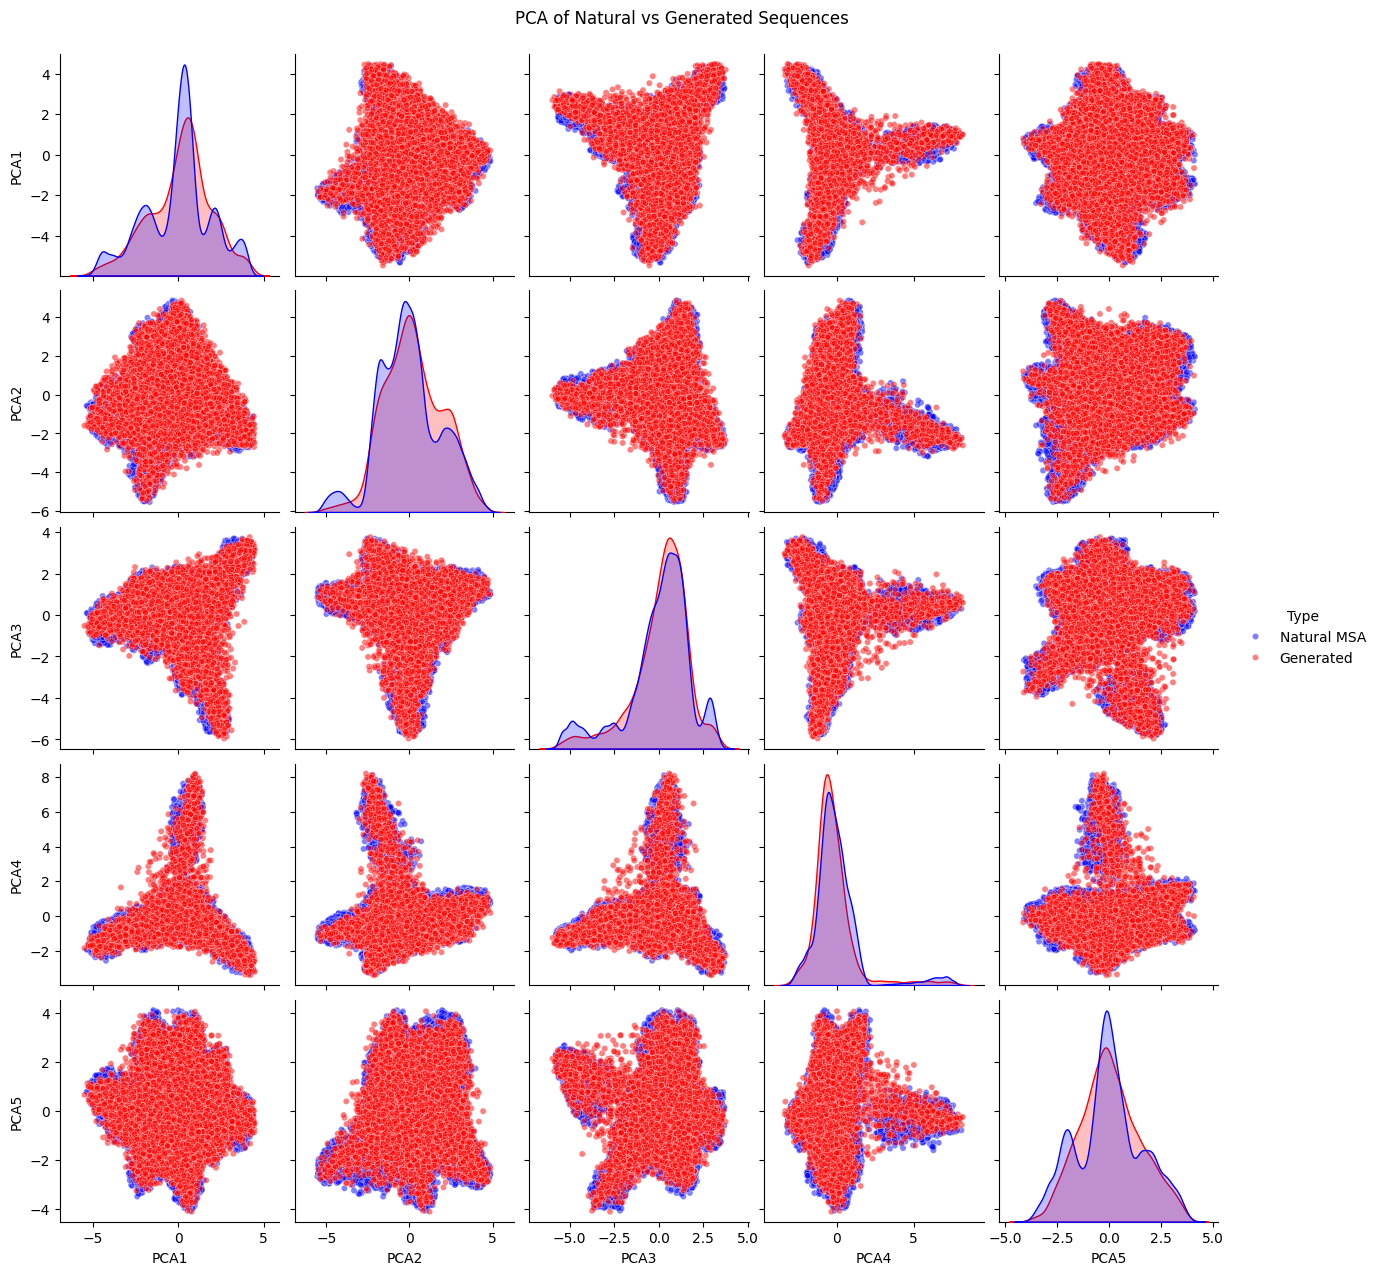

In [28]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(one_hot_matrix_flattened)

generated_pca = pca.transform(generated_flattened)

components = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
components['Type'] = 'Natural MSA'

generated_components = pd.DataFrame(generated_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'])
generated_components['Type'] = 'Generated'

combined_components = pd.concat([components, generated_components], axis=0)

pair_plot = sns.pairplot(
    combined_components,
    hue='Type',
    palette={'Natural MSA': 'blue', 'Generated': 'red'},
    diag_kind='kde',
    plot_kws={'alpha': 0.5, 's': 20},
    diag_kws={'common_norm': False}
)
plt.suptitle("PCA of Natural vs Generated Sequences", y=1.02)
plt.savefig('Natural_vs_Generated.png')
plt.show()

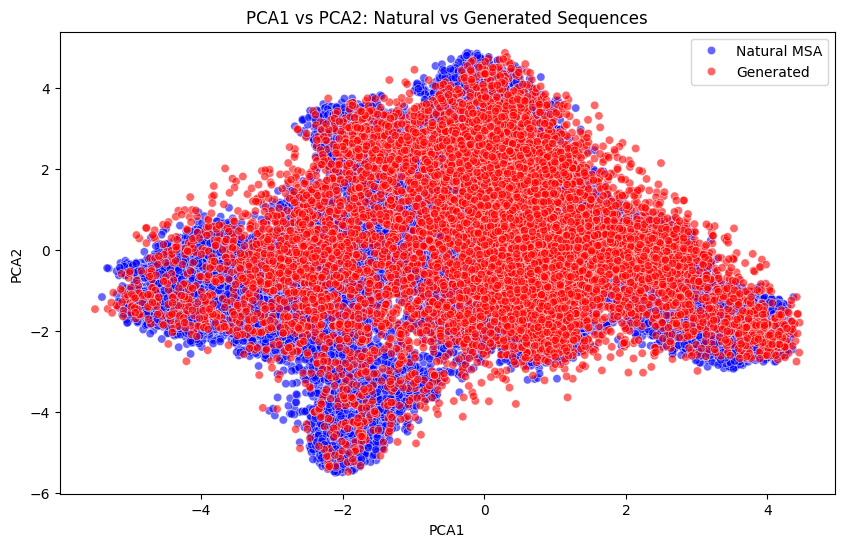

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combined_components,
    x='PCA1',
    y='PCA2',
    hue='Type',
    palette={'Natural MSA': 'blue', 'Generated': 'red'},
    alpha=0.6
)
plt.title("PCA1 vs PCA2: Natural vs Generated Sequences")
plt.legend()
plt.savefig('Natural_vs_Generated_2.png')
plt.show()

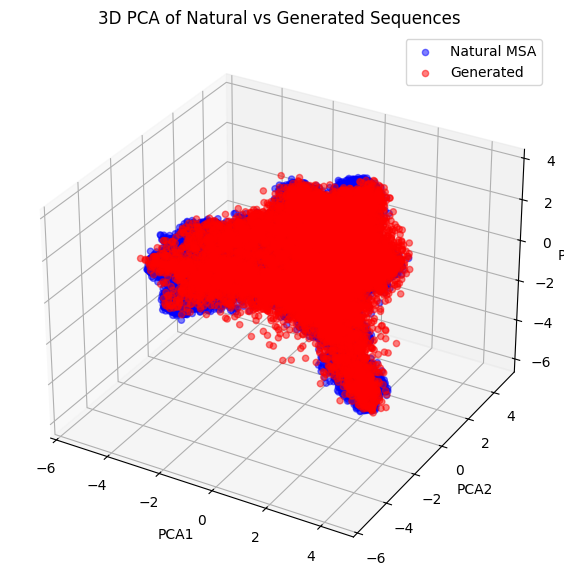

In [22]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    components['PCA1'], components['PCA2'], components['PCA3'],
    c='blue', label='Natural MSA', alpha=0.5
)
ax.scatter(
    generated_components['PCA1'], generated_components['PCA2'], generated_components['PCA3'],
    c='red', label='Generated', alpha=0.5
)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.legend()
plt.title("3D PCA of Natural vs Generated Sequences")
plt.show()

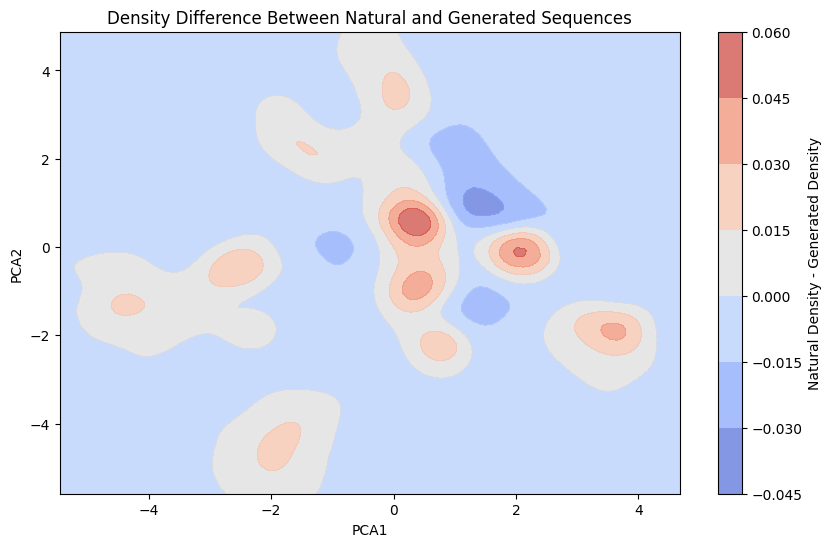

In [30]:
from scipy.stats import gaussian_kde

# Calculate density for PCA1/PCA2
natural_kde = gaussian_kde(components[['PCA1', 'PCA2']].T)
generated_kde = gaussian_kde(generated_components[['PCA1', 'PCA2']].T)

# Evaluate at grid points
xmin, xmax = combined_components['PCA1'].min(), combined_components['PCA1'].max()
ymin, ymax = combined_components['PCA2'].min(), combined_components['PCA2'].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

natural_density = natural_kde(positions).reshape(xx.shape)
generated_density = generated_kde(positions).reshape(xx.shape)

# Plot density difference
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, natural_density - generated_density, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Natural Density - Generated Density')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Density Difference Between Natural and Generated Sequences")
plt.show()

In [ ]:
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

natural_sequences = []
with open('sampled_seqs.fasta','r') as f:
   lines = f.readlines()
   for line in lines:
      if line[0] != ">":
        natural_sequences.append(line.strip())

# Create alignments
natural_aln = MultipleSeqAlignment([SeqRecord(Seq(s)) for s in natural_sequences])
generated_aln = MultipleSeqAlignment([SeqRecord(Seq(s)) for s in generated_sequences])

# Calculate Shannon entropy per position
def entropy(column):
    counts = Counter(column)
    total = sum(counts.values())
    return -sum((v/total) * np.log2(v/total) for v in counts.values())

natural_entropy = [entropy(natural_aln[:, i]) for i in range(len(natural_aln[0]))]
generated_entropy = [entropy(generated_aln[:, i]) for i in range(len(generated_aln[0]))]

plt.plot(natural_entropy, label="Natural")
plt.plot(generated_entropy, label="Generated")
plt.xlabel("Position")
plt.ylabel("Entropy (conservation)")
plt.legend()
plt.savefig('Entropy.png')

NameError: name 'generated_sequences' is not defined

In [36]:
from scipy.stats import pearsonr

cov_matrix_natural = np.cov(pca_result, rowvar=False)
cov_matrix_generated = np.cov(generated_pca, rowvar=False)

pearson_correlation, p_value = pearsonr(cov_matrix_natural.flatten(), cov_matrix_generated.flatten())

print(f"Pearson correlation of the 2-point connected correlations: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson correlation of the 2-point connected correlations: 0.9933847195000565
P-value: 3.986673519595713e-23


In [37]:
from scipy.stats import pearsonr
import numpy as np

# Supposons que cov_matrix_natural et cov_matrix_generated sont vos matrices de covariance
cov_matrix_natural = np.cov(pca_result, rowvar=False)
cov_matrix_generated = np.cov(generated_pca, rowvar=False)

# Extraire les éléments hors diagonale
def extract_off_diagonal(matrix):
    return matrix[~np.eye(matrix.shape[0], dtype=bool)].flatten()

off_diag_natural = extract_off_diagonal(cov_matrix_natural)
off_diag_generated = extract_off_diagonal(cov_matrix_generated)

# Calculer la corrélation de Pearson
pearson_correlation, p_value = pearsonr(off_diag_natural, off_diag_generated)

print(f"Pearson correlation of the 2-point connected correlations: {pearson_correlation}")
print(f"P-value: {p_value}")

Pearson correlation of the 2-point connected correlations: 0.12721739388376488
P-value: 0.5930094131799796


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 3. Création des étiquettes
natural_labels = np.zeros(pca_result.shape[0])
generated_labels = np.ones(generated_pca.shape[0])

# 4. Combinaison des données et des étiquettes
X = np.vstack((pca_result, generated_pca))
y = np.concatenate((natural_labels, generated_labels))

# 5. Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# 6. Entraînement du classifieur SVM
classifier = SVC(probability=True, random_state=42)
classifier.fit(X_train, y_train)

# 7. Prédictions sur les données de test
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:, 1]

# 8. Évaluation des performances
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred, target_names=['Natural', 'Generated'])

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.91
ROC AUC: 0.77
Classification Report:
              precision    recall  f1-score   support

     Natural       0.91      1.00      0.95     39758
   Generated       0.97      0.02      0.04      3997

    accuracy                           0.91     43755
   macro avg       0.94      0.51      0.50     43755
weighted avg       0.92      0.91      0.87     43755



In [13]:
labels_natural = np.zeros(one_hot_matrix_flattened.shape[0])
labels_generated = np.ones(generated_flattened.shape[0])

# Concatenate natural + artificial
X = np.vstack([one_hot_matrix_flattened, generated_flattened])
y = np.hstack([labels_natural, labels_generated])

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_shuffled,
    test_size=0.2,
    random_state=42
)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy logistic regression: {accuracy*100}%")

Accuracy logistic regression: 98.55556063445627%


In [17]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy Train logistic regression: {accuracy*100}%")

Accuracy Train logistic regression: 99.41602669592248%


In [15]:
from sklearn.ensemble import RandomForestClassifier

r_forest = RandomForestClassifier()
r_forest.fit(X_train, y_train)
y_pred = r_forest.predict(X_test)
# Évaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy random forest: {accuracy*100}%")

Accuracy random forest: 93.69200530237235%


In [16]:
r_forest = RandomForestClassifier()
r_forest.fit(X_train, y_train)
y_pred = r_forest.predict(X_train)
# Évaluation
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy Train random forest: {accuracy*100}%")

Accuracy Train random forest: 100.0%


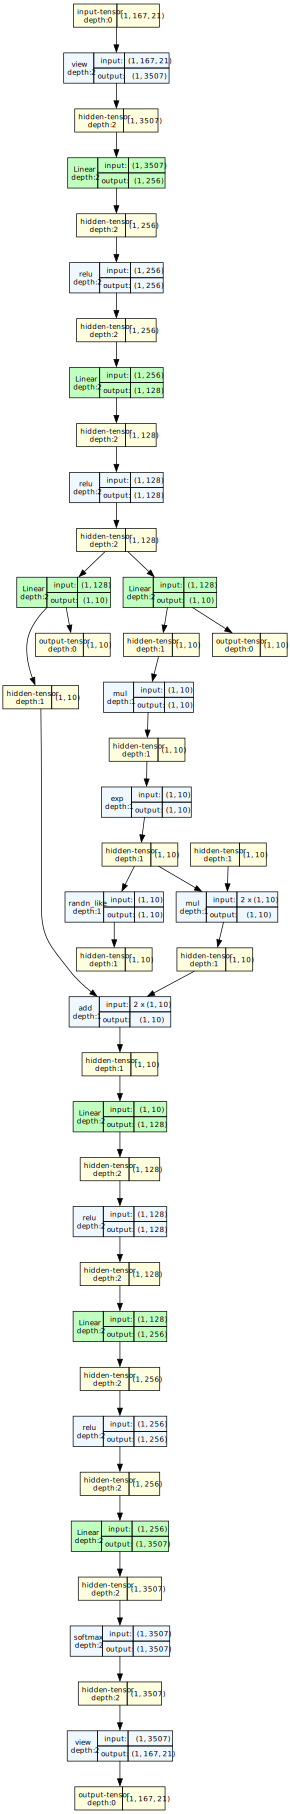

In [49]:
from torchview import draw_graph

# Visualisation
model.eval()
example_input = torch.randn(1, 167, 21)  # Batch_size=1, seq_len=167, aa_features=21

# Génération du graphe
graph = draw_graph(
    model,
    input_data=example_input,
    device='cpu',
    hide_module_functions=False,
    hide_inner_tensors=False,
    depth=2  # Profondeur de détail
)
graph.visual_graph  # Affiche dans un notebook
#graph.visual_graph.render(format='pdf')  # Pour sauvegarder